In [1779]:
import numpy as np
from qiskit.quantum_info import random_statevector
import math

# 2 Qubits

In [1780]:
n_qubits = 2

### Generate "unkown" state you want to learn

In [1781]:
psi = random_statevector(2**n_qubits).data.reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [1782]:
smaller_bases = False
smallest_bases = True

if smallest_bases is True:
    zero_zero = np.array([1, 0, 0, 0]).reshape(-1, 1)
    zero_one = np.array([0, 1, 0, 0]).reshape(-1, 1)
    one_zero = np.array([0, 0, 1, 0]).reshape(-1, 1)
    one_one = np.array([0, 0, 0, 1]).reshape(-1, 1)

    # phase on zero_one
    zero_one_plus = 1/np.sqrt(2) * np.array([1, 1, 0, 0]).reshape(-1, 1)
    zero_one_i = 1/np.sqrt(2) * np.array([1, 1j, 0, 0]).reshape(-1, 1)

    # phase on one_zero
    one_zero_plus = 1/np.sqrt(2) * np.array([1, 0, 1, 0]).reshape(-1, 1)
    one_zero_i = 1/np.sqrt(2) * np.array([1, 0, 1j, 0]).reshape(-1, 1)

    # phase on one_one

    # try changing this (Bell state, hard/impossible to measure directly) 
    one_one_plus = 1/np.sqrt(2) * np.array([1, 0, 0, 1]).reshape(-1, 1)
    one_one_i = 1/np.sqrt(2) * np.array([1, 0, 0, 1j]).reshape(-1, 1)

    # to (TODO: rename)
    one_one_plus = 1/np.sqrt(2) * np.array([0, 0, 1, 1]).reshape(-1, 1)
    one_one_i = 1/np.sqrt(2) * np.array([0, 0, 1, 1j]).reshape(-1, 1)


    basis_states = [zero_zero, zero_one, one_zero, one_one,
                    zero_one_plus, zero_one_i,
                    one_zero_plus, one_zero_i,
                    one_one_plus, one_one_i
                    ]
elif smaller_bases is True:
    zero = np.array([1, 0]).reshape(-1, 1)
    one = np.array([0, 1]).reshape(-1, 1)
    plus = 1/np.sqrt(2) * np.array([1, 1]).reshape(-1, 1)
    i = 1/np.sqrt(2) * np.array([1, 1j]).reshape(-1, 1)
    basis_states = [zero, one, plus, i]
else:
    zero = np.array([1, 0]).reshape(-1, 1)
    one = np.array([0, 1]).reshape(-1, 1)
    plus = 1/np.sqrt(2) * np.array([1, 1]).reshape(-1, 1)
    minus = 1/np.sqrt(2) * np.array([1, -1]).reshape(-1, 1)
    i = 1/np.sqrt(2) * np.array([1, 1j]).reshape(-1, 1)
    minus_i = 1/np.sqrt(2) * np.array([1, -1j]).reshape(-1, 1)
    basis_states = [zero, one, plus, minus, i, minus_i]

### Create measurement projectors

In [1783]:
# 2 qubits
if smallest_bases is True:
    measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
    two_qubit_measurement_operators = measurement_operators
else: 
    measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
    two_qubit_measurement_operators = []
    for qubit_1_op in measurement_operators:
        for qubit_2_op in measurement_operators:
            two_qubit_measurement_operators.append(np.kron(qubit_1_op, qubit_2_op))

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [1784]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in two_qubit_measurement_operators]

probabilities = get_probabilities(unkown_dm)

### Create tunable state
Parameterization from: https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf

In [1785]:
def get_parameterized_dm(t):
    """ t is a list of the tunable parameters """
    T = np.array([[t[0], 0, 0, 0],
                  [t[4] + 1j*t[5], t[1], 0, 0],
                  [t[10] + 1j*t[11], t[6] + 1j*t[7], t[2], 0],
                  [t[14] + 1j*t[15], t[12] + 1j*t[13], t[8] + 1j*t[9], t[3]]
                 
                 ])
    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    return parameterized_rho

In [1786]:
dm_parameters = np.random.uniform(low=-1, high=1, size=16)

In [1787]:
parameterized_dm = get_parameterized_dm(dm_parameters)

### Test that DM is valid

In [1788]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [1789]:
def get_probabilites_from_parameters(t):
    parameterized_dm = get_parameterized_dm(t)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [1790]:
from scipy.special import kl_div

def kl_divergence(true_probs, t):
    probs = get_probabilites_from_parameters(t)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, params)

In [1791]:
from scipy.optimize import minimize

optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")

In [1792]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(found_params)

# Density Matrix Fidelity: "Unknown" DM vs. Reconstructed DM

In [1793]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

print("Density matrix fidelity:", dm_fidelity(unkown_dm, found_dm))

Density matrix fidelity: 0.9995510365077165


### Plot Density Matrices

In [1794]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [1795]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

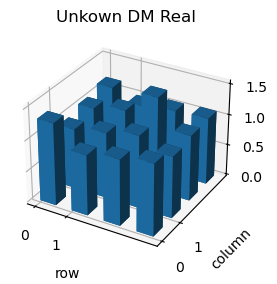

[[1.32972329 0.97635523 1.06682028 1.16292232]
 [0.97635523 1.0639756  1.17352119 0.99870179]
 [1.06682028 1.17352119 1.52406651 1.06275055]
 [1.16292232 0.99870179 1.06275055 1.0822346 ]]


In [1796]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

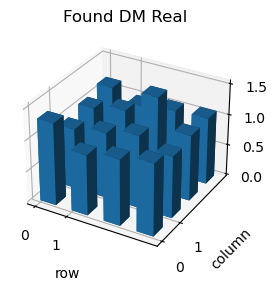

[[1.32978096 0.97633568 1.06679833 1.16280981]
 [0.97633568 1.06397627 1.17309925 0.99865507]
 [1.06679833 1.17309925 1.52399787 1.06270632]
 [1.16280981 0.99865507 1.06270632 1.0822449 ]]


In [1797]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

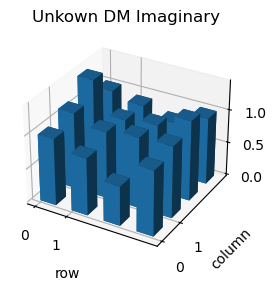

[[1.         0.85669903 0.58971719 0.97610477]
 [1.14330097 1.         1.05846251 1.07252119]
 [1.41028281 0.94153749 1.         1.19788575]
 [1.02389523 0.92747881 0.80211425 1.        ]]


In [1798]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

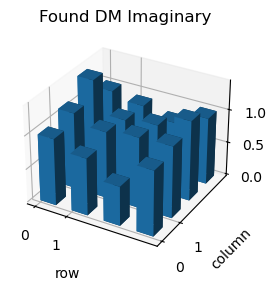

[[1.         0.85680677 0.58992365 0.97612014]
 [1.14319323 1.         1.05851498 1.0724006 ]
 [1.41007635 0.94148502 1.         1.19780998]
 [1.02387986 0.9275994  0.80219002 1.        ]]


In [1799]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)

## Reconstruct state vector from the density matrix 

In [1800]:
def density_matrix_to_state_vector(rho):
    """Extracts a state vector from a pure-state density matrix."""
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Find the eigenvector corresponding to eigenvalue ~1
    idx = np.argmax(eigenvalues)  # The largest eigenvalue (should be ~1 for a pure state)
    
    # Extract the corresponding eigenvector
    state_vector = eigenvectors[:, idx]

    # Normalize the state vector
    state_vector = state_vector / np.linalg.norm(state_vector)

    return state_vector

#### original psi

In [1801]:
print("original psi", psi)

prob_0 = np.abs(psi[0])**2
prob_1 = np.abs(psi[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original psi [[ 0.54982052+0.16559191j]
 [-0.11139601+0.22708264j]
 [-0.09462587+0.71771335j]
 [ 0.25967586+0.12166779j]]
prob_0 [0.32972329]
prob_1 [0.0639756]


#### original psi from density matrix, testing that it matches psi

In [1802]:
original_psi_from_dm = density_matrix_to_state_vector(unkown_dm)
print("original_psi_from_dm", original_psi_from_dm)

prob_0 = np.abs(original_psi_from_dm[0])**2
prob_1 = np.abs(original_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original_psi_from_dm [ 0.57421537+0.j         -0.04117753+0.24955963j  0.11636797+0.71451033j
  0.28373033+0.04161371j]
prob_0 0.3297232882078949
prob_1 0.06397559554633606


#### statevector from reconstructed dm

In [1803]:
found_psi_from_dm = density_matrix_to_state_vector(found_dm)
print("found_psi_from_dm", found_psi_from_dm)
prob_0 = np.abs(found_psi_from_dm[0])**2
prob_1 = np.abs(found_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

found_psi_from_dm [ 0.57429755+0.j         -0.04130273+0.24927817j  0.11641914+0.71453731j
  0.28370846+0.0415852j ]
prob_0 0.3298176730625588
prob_1 0.06384552057670492


### State vector fidelity

In [1804]:
def statevector_fidelity(psi, phi):
    """Computes the fidelity between two state vectors."""
    psi = np.array(psi, dtype=complex)
    phi = np.array(phi, dtype=complex)
    
    # Normalize the state vectors
    psi /= np.linalg.norm(psi)
    phi /= np.linalg.norm(phi)
    
    # Compute fidelity
    fidelity = np.abs(np.vdot(psi, phi)) ** 2
    return fidelity

In [1805]:
statevector_fidelity(psi, found_psi_from_dm)

0.9999998937194982

# Analytic Solution

In [1806]:
probabilities

[0.32972328820789476,
 0.06397559554633607,
 0.5240665128436193,
 0.08223460340214997,
 0.17320467387555158,
 0.3401504142211595,
 0.493715177085573,
 0.8371777109077088,
 0.36590110345535115,
 0.10526480598160282]

In [1807]:
alpha_00 = np.sqrt(probabilities[0])
alpha_01 = np.sqrt(probabilities[1])
alpha_10 = np.sqrt(probabilities[2])
alpha_11 = np.sqrt(probabilities[3])

phi_01 = math.atan2(2*probabilities[5] - alpha_00**2 - alpha_01**2,
                 2*probabilities[4] - alpha_00**2 - alpha_01**2)
                 
phi_10 = math.atan2(2*probabilities[7] - alpha_00**2 - alpha_10**2,
                 2*probabilities[6] - alpha_00**2 - alpha_10**2)

# phi_11 = math.atan2(2*probabilities[9] - alpha_00**2 - alpha_11**2,
#                  2*probabilities[8] - alpha_00**2 - alpha_11**2)

phi_11 = math.atan2(2*probabilities[9] - alpha_10**2 - alpha_11**2,
                 2*probabilities[8] - alpha_10**2 - alpha_11**2) + phi_10

In [1808]:
analytic_psi = np.array([alpha_00,
                         alpha_01 * np.exp(1j * phi_01),
                         alpha_10 * np.exp(1j * phi_10),
                         alpha_11 * np.exp(1j * phi_11)]).reshape(-1, 1)

In [1809]:
statevector_fidelity(psi, analytic_psi)

1.0000000000000009

In [1810]:
import cmath

def rectangular_to_polar(complex_num):
  """Converts a complex number from rectangular form to polar form.

  Args:
    complex_num: A complex number in rectangular form (a + bi).

  Returns:
    A tuple containing the magnitude (r) and phase angle (theta) in radians.
  """
  r = abs(complex_num)
  theta = cmath.phase(complex_num)
  return (r, theta)

r, theta = rectangular_to_polar(psi[0])

/var/folders/x0/ws0sf7zx7v1gkqlvt7xbmlc40000gn/T/ipykernel_35565/2553347791.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta = cmath.phase(complex_num)


In [1811]:
psi

array([[ 0.54982052+0.16559191j],
       [-0.11139601+0.22708264j],
       [-0.09462587+0.71771335j],
       [ 0.25967586+0.12166779j]])

In [1812]:
psi * np.exp(-1j * theta)

array([[ 0.57421537-5.70007912e-18j],
       [-0.04117753+2.49559626e-01j],
       [ 0.11636797+7.14510328e-01j],
       [ 0.28373033+4.16137054e-02j]])

In [1813]:
analytic_psi

array([[ 0.57421537+0.j        ],
       [-0.04117753+0.24955963j],
       [ 0.11636797+0.71451033j],
       [ 0.28373033+0.04161371j]])